### QuasarNET: Inspect DESI sims

This notebook will walk you through how to run [QuasarNET](https://arxiv.org/pdf/1808.09955.pdf]):
 * load training data
 * load DESI sims validation data
 * train the network (on a small training sample, optional)
 * load pre-trained weights
 * plot example spectra
 * produce QA plots and confusion matrix

#### Installation instructions (requires python3):
##### - on a standard system

```bash
git clone https://github.com/ngbusca/QuasarNET.git
cd QuasarNET
pip install -r requirements.txt --user
python setup.py install --user
```

##### - at NERSC (e.g. if you wish to run this notebook at jupyter.nersc.gov)

```bash
conda create -n qnet python=3 qnet scipy numpy fitsio h5py ipykernel
source activate qnet
python -m ipykernel install --user --name qnet --display-name qnet
pip install tensorflow
pip install keras>=2.2.4
git clone https://github.com/ngbusca/QuasarNET.git
cd QuasarNET
python setup.py install
```

#### - Download the pre-trained weights
The pre-trained weights are available at: https://www.kaggle.com/ngbusca/qnet_trained_models

Download the weights to the `QuasarNET/weights/` directory, unzip the file and set read/write permissions
(skip the `kaggle datasets...` line if you've downloaded the data through the website).

```bash
cd weights
kaggle datasets download ngbusca/qnet_trained_models
unzip qnet_trained_models.zip
chmod 600 *
```

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import fitsio
import glob
from keras.optimizers import Adam
from keras.models import load_model
from quasarnet.models import QuasarNET, custom_loss
from quasarnet.io import read_truth, read_data, read_desi_spectra, read_desi_truth, wave, objective
from quasarnet.utils import process_preds, absorber_IGM
%matplotlib inline

Using TensorFlow backend.


#### Load the DESI sims

The next cell loads all spectra from a spectra file. It firsts gets the resampled fluxes on the QNet wavelength grid, then removes the mean and sets the rms of the flux to1.

In [2]:
#Determine how many pixels to load
n_pix = 50
basedir = '/project/projectdirs/desi/users/jfarr/quickquasars_runs/desi-0.3-4/'

In [3]:
fi = glob.glob(basedir+'/spectra-16/*/*/spectra-16-*.fits')
fi.sort()
fi = fi[:n_pix]
print(len(fi))
tids_val, flux = read_desi_spectra(fi[0], ignore_quasar_mask=True)
for f in fi[1:]:
    tids_val_f, flux_f = read_desi_spectra(f, ignore_quasar_mask=True)
    tids_val = np.append(tids_val,tids_val_f)
    flux = np.append(flux,flux_f,axis=0)
mflux = np.average(flux[:,:443], weights=flux[:,443:],axis=1)
sflux = np.average((flux[:,:443]-mflux[:,None])**2, weights=flux[:,443:], axis=1)
sflux = np.sqrt(sflux)
X_val_desi = (flux[:,:443]-mflux[:,None])/sflux[:,None]
nspec_desi = X_val_desi.shape[0]

#Make a truth table for the desi spectra
#Y_val_desi = np.zeros((nspec_desi,5))


50
WARN: can't load desi_mask, ignoring mask!
INFO: found 1326 quasar targets
INFO: founds 1326 good spectra
WARN: can't load desi_mask, ignoring mask!
INFO: found 1151 quasar targets
INFO: founds 1151 good spectra
WARN: can't load desi_mask, ignoring mask!
INFO: found 1247 quasar targets
INFO: founds 1247 good spectra
WARN: can't load desi_mask, ignoring mask!
INFO: found 1132 quasar targets
INFO: founds 1132 good spectra
WARN: can't load desi_mask, ignoring mask!
INFO: found 1261 quasar targets
INFO: founds 1261 good spectra
WARN: can't load desi_mask, ignoring mask!
INFO: found 1199 quasar targets
INFO: founds 1199 good spectra
WARN: can't load desi_mask, ignoring mask!
INFO: found 1243 quasar targets
INFO: founds 1243 good spectra
WARN: can't load desi_mask, ignoring mask!
INFO: found 1155 quasar targets
INFO: founds 1155 good spectra
WARN: can't load desi_mask, ignoring mask!
INFO: found 1255 quasar targets
INFO: founds 1255 good spectra
WARN: can't load desi_mask, ignoring mask!


In [5]:
#Load some truth data
#At the moment, the function
fi_truth = glob.glob(basedir+'/spectra-16/*/*/truth-16-*.fits')
fi_truth.sort()
fi_truth = fi_truth[:n_pix]
h = fitsio.FITS(fi_truth[0])
tids_bal_truth = h[4]['TARGETID'][:]
tempids_bal_truth = h[4]['TEMPLATEID'][:]
tids_truth = h[1]['TARGETID'][:]
z_truth = h[1]['TRUEZ'][:]
for i,f in enumerate(fi_truth[1:]):
    h = fitsio.FITS(f)
    tids_bal_truth = np.concatenate((tids_bal_truth,h[4]['TARGETID'][:]))
    tempids_bal_truth = np.concatenate((tempids_bal_truth,h[4]['TEMPLATEID'][:]))
    tids_truth = np.concatenate((tids_truth,h[1]['TARGETID'][:]))
    z_truth = np.concatenate((z_truth,h[1]['TRUEZ'][:]))


#### Define the "features" that the network was trained to recognize

The features are defined by their rest wavelength. 
A dictionary `{feature_name:feature_wavelength}` is defined in `quasarnet.util.absorber_IGM`, which currently contains typical quasar broad emission lines. It could be easily extended to include other features by extending the dictionary.

In [6]:
lines=['LYA','CIV(1548)','CIII(1909)', 'MgII(2796)','Hbeta','Halpha']
lines_bal=['CIV(1548)']

#### Load a pre-trained model

The following cell loads pre-trained weights for the network, corresponding to the split defined earlier. The pre-training was done over the full training data sample and 200 epochs.

In [7]:
imodel=0
model = load_model('../weights/qn_train_{}.h5'.format(imodel),custom_objects={'custom_loss':custom_loss})
#model = load_model('../runs/v18.0/qn_train_{}.h5'.format(imodel),custom_objects={'custom_loss':custom_loss})

W1009 09:58:22.269641 46912496621568 deprecation_wrapper.py:119] From /global/homes/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1009 09:58:22.288304 46912496621568 deprecation_wrapper.py:119] From /global/homes/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1009 09:58:22.361341 46912496621568 deprecation_wrapper.py:119] From /global/homes/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1009 09:58:22.361840 46912496621568 deprecation_wrapper.py:119] From /global/homes/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_

#### Example spectra

Let's now take a look at the network output by examining a few examples. If you skipped loading the pre-trained weights you will be looking at the model you trained (it's actually not that bad!).

The network outputs confidences and positions of the features defined earlier. The following plot shows a spectrum from the validation sample and the detected features. You can change the index `ival` to change the spectrum to be shown.

In [8]:
def show_spec_pred(X,tid,show_bal=True):
    
    p = model.predict(X)
    c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p, lines, lines_bal)
    X = X.reshape(X.shape[1])
    plt.plot(wave, X)
    ztrue = z_truth[tids_truth==tid]
    plt.title(r'TARGETID = {}, z$_{{pred}}$ = {:1.3f}, z$_{{ann}}$ = {:1.3f}'.format(tids_val[ival],zbest[0],ztrue[0]))
    m = X.min()
    M = X.max()
    plt.grid()
    plt.ylim(m-2,M+2)
    for il,l in enumerate(lines):
        lam = absorber_IGM[l]*(1+z_line[il])
        w = abs(wave-lam)<100
        m = X[w].min()-1
        M = X[w].max()+1
        plt.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il])
        plt.text(lam,M+0.5,'c$_{{{}}}={}$'.format(l,round(c_line[il,0],3)),
                 horizontalalignment='center',alpha=0.1+0.9*c_line[il])
        
    if show_bal:
        for il,l in enumerate(lines_bal):
            lam = absorber_IGM[l]*(1+z_line_bal[il])
            w = abs(wave-lam)<100
            m = X_val_desi[ival,w].min()-1
            M = X_val_desi[ival,w].max()+1
            #plt.plot([lam,lam], [m,M],'r--', alpha=0.1+0.9*c_line[il])
            plt.text(lam,M+2.0,'c$_{{{}}}={}$'.format('BAL'+l,round(c_line_bal[il,0],3)),
                     horizontalalignment='center',alpha=0.1+0.9*c_line_bal[il],c='r')
    
    plt.show()

    return

INFO: nspec = 1, nboxes=13


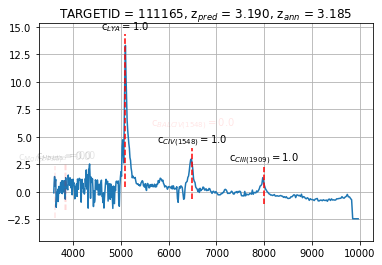

In [9]:
ival = 100
show_spec_pred(X_val_desi[ival:ival+1,:,None],tids_val[ival])

#### Quality assesment

The next cells assume that simulated spectra are all quasars and there are no BALs in the sample. 

QuasarNET calls a spectrum a quasar if there are more than `nlines` detected with a confidence greater than `c_th`, and similarly for BAL quasars.

In [38]:
## minimum number of lines required for quasar
nlines = 1
## line detection threshold
c_th = 0.4

## same thing for BAL
nlines_bal = 1
c_th_bal = 0.4

In [39]:
p_desi = model.predict(X_val_desi[:,:,None])
c_line_desi, z_line_desi, zbest_desi, c_line_bal_desi, z_line_bal_desi = process_preds(p_desi, lines, lines_bal)
isqso_desi = (c_line_desi>c_th).sum(axis=0)>=nlines
isbal_desi = isqso_desi & ((c_line_bal_desi>c_th_bal).sum(axis=0)>=nlines_bal)
nqso_desi = isqso_desi.sum()
nbal_desi = isbal_desi.sum()
tids_bal = tids_val[c_line_bal_desi[0,:]>c_th_bal]

INFO: nspec = 61113, nboxes=13


In [40]:
print(' -> INFO: found {} QSOs out of {} spectra ({:.2%})'.format(nqso_desi, nspec_desi, nqso_desi/nspec_desi))
print(' -> INFO: found {} BAL out of {} spectra ({:.2%})'.format(nbal_desi, nspec_desi, nbal_desi/nspec_desi))

 -> INFO: found 61110 QSOs out of 61113 spectra (100.00%)
 -> INFO: found 6944 BAL out of 61113 spectra (11.36%)


### Let's look at how well we find BALs

In [41]:
print('INFO: {:5d} BAL QSOs in input'.format(tids_bal_truth.shape[0]))
print('INFO: {:5d} BAL QSOs found by QN'.format(tids_bal.shape[0]))
print('INFO: {:5d} of these were actually BAL QSOs'.format(np.sum(np.in1d(tids_bal,tids_bal_truth))))
print('INFO: {:5d} of these were not BAL QSOs'.format(-np.sum(np.in1d(tids_bal,tids_bal_truth))+tids_bal.shape[0]))

INFO:  9661 BAL QSOs in input
INFO:  6944 BAL QSOs found by QN
INFO:  6848 of these were actually BAL QSOs
INFO:    96 of these were not BAL QSOs


In [42]:
print('QN BAL sample:')
print(' -> {:3.2%} purity'.format(np.sum(np.in1d(tids_bal,tids_bal_truth))/tids_bal.shape[0]))
print(' -> {:3.2%} completeness'.format(np.sum(np.in1d(tids_bal,tids_bal_truth))/tids_bal_truth.shape[0]))

QN BAL sample:
 -> 98.62% purity
 -> 70.88% completeness


INFO: nspec = 1, nboxes=13


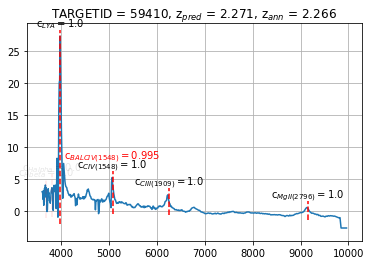

In [45]:
# Show a correctly identified BAL spectrum (true positive)
ival = 0
bal_tid = tids_bal[ival]
ival = np.where(tids_val==bal_tid)[0][0]
show_spec_pred(X_val_desi[ival:ival+1,:,None],tids_val[ival])

INFO: nspec = 1, nboxes=13


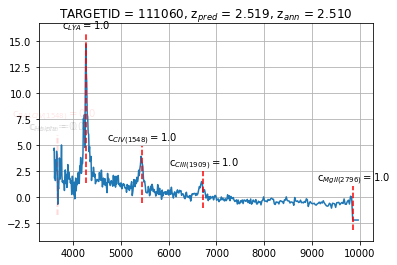

In [48]:
# Show a BAL spectrum that QN missed (false negative)
ival = 2
missed_bal_tids = tids_bal_truth[~np.in1d(tids_bal_truth,tids_bal)]
bal_tid = missed_bal_tids[ival]
ival = np.where(tids_val==bal_tid)[0][0]
show_spec_pred(X_val_desi[ival:ival+1,:,None],tids_val[ival])

INFO: nspec = 1, nboxes=13


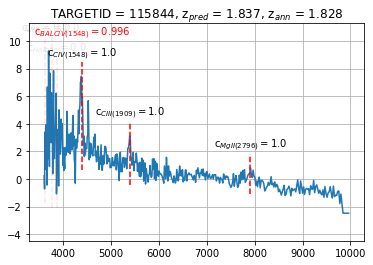

In [49]:
# Show a BAL spectrum that QN incorrectly flagged (false positive)
ival = 4
flagged_non_bal_tids = tids_bal[~np.in1d(tids_bal,tids_bal_truth)]
bal_tid = flagged_non_bal_tids[ival]
ival = np.where(tids_val==bal_tid)[0][0]
show_spec_pred(X_val_desi[ival:ival+1,:,None],tids_val[ival])

INFO: 148/543 (27.3%) TEMPIDs are missed more than they're than positively identified.
INFO:  67/543 (12.3%) TEMPIDs are never positively identified.


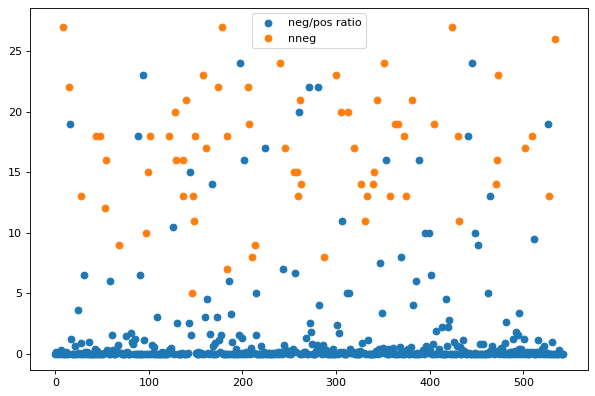

In [50]:
#Plot histograms of the template IDs that QN picked up or missed.
tp = np.in1d(tids_bal_truth,tids_bal)
temp_pos = tempids_bal_truth[tp]
temp_neg = tempids_bal_truth[~tp]
temps = np.linspace(0,np.max(tempids_bal_truth),np.max(tempids_bal_truth)+1)
temp_bins = np.linspace(0-0.5,np.max(tempids_bal_truth)+0.5,np.max(tempids_bal_truth)+2)

neg_pos_ratio = []
t_neg_pos_ratio = []
no_pos = []
t_no_pos = []
allinone = []
nneg_list = []
npos_list = []
for i,t in enumerate(temps):
    nneg = np.sum(temp_neg==t)
    npos = np.sum(temp_pos==t)
    if npos==0:
        no_pos += [nneg]
        t_no_pos += [t]
        allinone += [-1]
        nneg_list += [nneg]
        npos_list += [npos]
    else:
        neg_pos_ratio += [nneg/npos]
        t_neg_pos_ratio += [t]
        allinone += [nneg/npos]
        nneg_list += [nneg]
        npos_list += [npos]
        
neg_pos_ratio = np.array(neg_pos_ratio)
t_neg_pos_ratio = np.array(t_neg_pos_ratio)
no_pos = np.array(no_pos)
t_no_pos = np.array(t_no_pos)
allinone = np.array(allinone)
nneg = np.array(nneg_list)
npos = np.array(npos_list)

plt.figure(figsize=(9,6),dpi=80)
plt.scatter(t_neg_pos_ratio,neg_pos_ratio,label='neg/pos ratio')
plt.scatter(t_no_pos,no_pos,label='nneg')
plt.legend()

#_ = plt.hist(temp_pos,bins=temp_bins,alpha=0.5)
#_ = plt.hist(temp_neg,bins=temp_bins,alpha=0.5)

print('INFO: {:3d}/{:3d} ({:.1%}) TEMPIDs are missed more than they\'re than positively identified.'.format(np.sum(neg_pos_ratio>1)+len(no_pos),len(temps),(np.sum(neg_pos_ratio>1)+len(no_pos))/len(temps)))
print('INFO: {:3d}/{:3d} ({:.1%}) TEMPIDs are never positively identified.'.format(len(no_pos),len(temps),len(no_pos)/len(temps)))

plt.show()

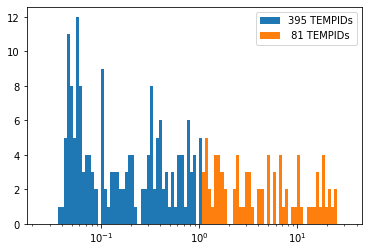

In [51]:
bins = np.logspace(-1.6,1.5,100)
_ = plt.hist(neg_pos_ratio[neg_pos_ratio<=1],bins=bins,label='{:3d} TEMPIDs'.format(np.sum(neg_pos_ratio<=1)))
_ = plt.hist(neg_pos_ratio[neg_pos_ratio>1],bins=bins,label='{:3d} TEMPIDs'.format(np.sum(neg_pos_ratio>1)))
#plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

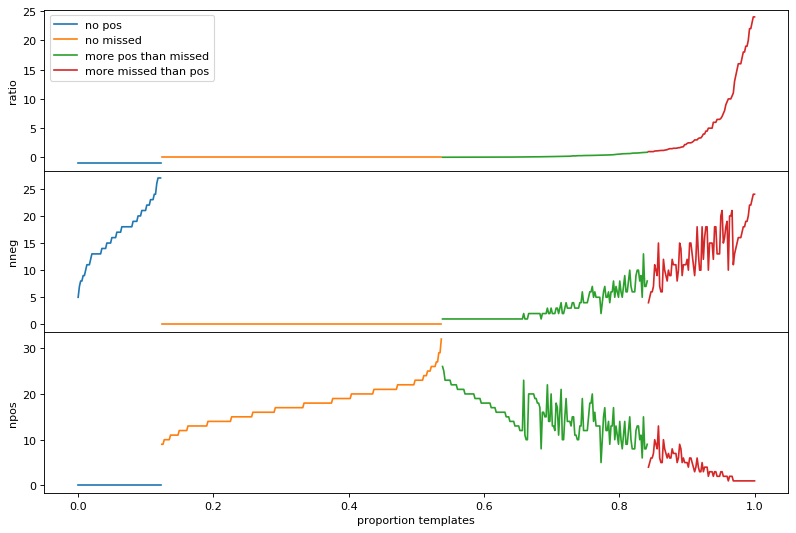

In [56]:
names = ['ratio','nneg','npos']
fmts = ['d',int,int]
dtype = list(zip(names,fmts))
data = np.array(list(zip(allinone,nneg,npos)),dtype=dtype)
data.sort(order=['ratio','nneg'])
fig, axs = plt.subplots(3,1,figsize=(12,8),dpi=80)

regions = []
region_names = []
regions += [data['ratio']==-1]
region_names += ['no pos']
regions += [data['nneg']==0]
region_names += ['no missed']
regions += [(data['ratio']>-1) * (data['ratio']<1) * (data['nneg']>0)]
region_names += ['more pos than missed']
regions += [(data['ratio']>=1) * (data['nneg']>0)]
region_names += ['more missed than pos']

for i,name in enumerate(names):
    for j,region in enumerate(regions):
        axs[i].plot(temps[region]/np.max(temps),data[name][region],label=region_names[j])
    axs[i].set_ylabel(name)

axs[0].legend(loc=2)

#axs[1].plot(temps,data['nneg'])
#axs[2].plot(temps,data['npos'])
fig.subplots_adjust(hspace=0)
plt.xlabel('proportion templates')
plt.savefig('bal_success.pdf')
plt.show()

In [ ]:
#Plot an example spectrum for a template which has more neg than pos, but still at least 1 pos identification
ival_temp = 4
ival = 0
bad_tempids = np.array(t_neg_pos_ratio)[np.array(neg_pos_ratio)>1]
for bad_tempid in bad_tempids:
    print('INFO: TEMPID {} has a n/p ratio of {:2.1f}'.format(bad_tempid,neg_pos_ratio[t_neg_pos_ratio==bad_tempid][0]))
    tids = tids_bal_truth[np.in1d(tempids_bal_truth,bad_tempid)]
    for tid in tids:
        ival = np.where(tids_val==tid)[0][0]
        show_spec_pred(X_val_desi[ival:ival+1,:,None],tids_val[ival])

In [ ]:
#Plot an example spectrum for a template which QN never positively identifies
ival_temp = 0
ival = 0
bad_tempids = np.array(t_no_pos)
bad_tempid = bad_tempids[ival_temp]
print('INFO: TEMPID {} is never identified positively, with {} misses'.format(bad_tempid,no_pos[t_no_pos==bad_tempid][0]))
tid = tids_bal_truth[np.in1d(tempids_bal_truth,bad_tempid)][ival]
ival = np.where(tids_val==tid)[0][0]
show_spec_pred(X_val_desi[ival:ival+1,:,None],tids_val[ival])

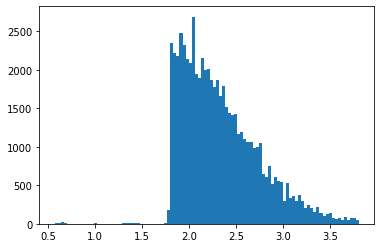

In [11]:
_=plt.hist(zbest_desi, bins=100)

We now want to compare how well the model works for DESI data compared to BOSS. First we load the BOSS data

In [89]:
## Get the BOSS data for comparison.
## set nspec to the number of spectra to load or to None for the full sample
nspec = 1000000
isplit = 0
truth_file = (['../data/truth_DR12Q.fits'])
truth = read_truth(truth_file)
tids_full,X_full,Y_full,z_full,bal_full = read_data(['../data/data_dr12.fits'], truth, nspec=nspec)

#Get the training data
data_file = '../data/data_train_{}.fits'.format(imodel)
h = fitsio.FITS(data_file)
tids_train = h[1]['TARGETID'][:]

## to get the validation data, remove the spectra in the training sample from the full sample
w = ~np.in1d(tids_full, tids_train)
tids_val = tids_full[w]
X_val_boss = X_full[w]
Y_val_boss = Y_full[w]
z_val_boss = z_full[w]
bal_val_boss = bal_full[w]

INFO: reading data from ../data/data_dr12.fits
INFO: removing 20766 spectra missing in truth
INFO: found (617289,) spectra in file ../data/data_dr12.fits
INFO: removing 2567 spectra with zero weights
INFO: removing 7 spectra with zero flux


In [90]:
## We then filter to leave only QSOs as there are only QSOs in the DESI sims.
w_qso = np.sum(Y_val_boss[:,2:4],axis=1)>0
X_val_boss = X_val_boss[w_qso,:]
Y_val_boss = Y_val_boss[w_qso,:]
z_val_boss = z_val_boss[w_qso]
bal_val_boss = bal_val_boss[w_qso]

n_spec_boss = X_val_boss.shape[0]
print('INFO: number of QSOs is',n_spec_boss)

INFO: number of QSOs is 34494


In [91]:
X_sets = [X_val_boss, X_val_desi]
#truths = [Y_val_boss, Y_val_desi]
names = ['boss', 'desi']

In [92]:
for i,X in enumerate(X_sets):
    print('Looking at {} data...'.format(names[i]))
    nspec = X.shape[0]
   
    p_val = model.predict(X[:,:,None])
    c_line, z_line, zbest, c_line_bal, z_line_bal = process_preds(p_val, lines, lines_bal)
    isqso = (c_line>c_th).sum(axis=0)>=nlines
    isbal = isqso & ((c_line_bal>c_th_bal).sum(axis=0)>=nlines_bal)
    nqso = isqso.sum()
    nbal = isbal.sum()

    print(' -> INFO: found {} QSOs out of {} spectra ({:.2%})'.format(nqso, nspec, nqso/nspec))
    print(' -> INFO: found {} BAL out of {} spectra ({:.2%})'.format(nbal, nspec, nbal/nspec))
    print(' ')

Looking at boss data...
INFO: nspec = 34494, nboxes=13
 -> INFO: found 34332 QSOs out of 34494 spectra (99.53%)
 -> INFO: found 4639 BAL out of 34494 spectra (13.45%)
 
Looking at desi data...
INFO: nspec = 80261, nboxes=13
 -> INFO: found 80254 QSOs out of 80261 spectra (99.99%)
 -> INFO: found 1036 BAL out of 80261 spectra (1.29%)
 
